In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.integrate import cumulative_simpson
import numpy as np
import lisa
import feathers
import cmcrameri.cm as cm

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


In [2]:
import utils.load_grid as lg
from proteus.utils.constants import R_earth

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# %matplotlib widget

In [4]:
class Grid():
    def __init__(self):
        self.dir = ""
        self.cases = None
        self.stts = None
        self.cvars = None
        self.ncases = 0
        self.helps = None
        self.hvars = None
        return

In [5]:
def load_grid(pgrid_dir):
    print(f"Loading grid {pgrid_dir}")

    cases = lg.get_cases(pgrid_dir)

    # Collect netcdf files
    stts = lg.get_statuses(pgrid_dir)

    # Configuration variables
    cvars = lg.load_configs(cases)
    ncases = len(cases)

    # Helpfiles
    helps, hvars = lg.load_helpfiles(cases)

    gr = Grid()
    gr.dir = pgrid_dir
    gr.cases = cases
    gr.stts = stts
    gr.ncases = ncases
    gr.cvars = cvars
    gr.helps = helps
    gr.hvars = hvars

    print("    done")

    return gr



In [6]:
gr_ecc = load_grid("data/shared/l98d_sens_eccentric/")
gr_esc = load_grid("data/shared/l98d_sens_escape/")
gr_crf = load_grid("data/shared/l98d_sens_corefrac/")
gr_ban = load_grid("data/shared/l98d_sens_bands/")

Loading grid data/shared/l98d_sens_eccentric/


Helpfiles: 100%|██████████| 25/25 [00:01<00:00, 14.02it/s]


    done
Loading grid data/shared/l98d_sens_escape/


Helpfiles: 100%|██████████| 26/26 [00:02<00:00, 11.85it/s]


    done
Loading grid data/shared/l98d_sens_corefrac/


Helpfiles: 100%|██████████| 25/25 [00:02<00:00, 12.30it/s]


    done
Loading grid data/shared/l98d_sens_bands/


Helpfiles: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]

    done


In [7]:
alphabet = "abcdefghijklmnopqrstuvwxyz"

Plotting grid data/shared/l98d_sens_eccentric/
[0.   0.05 0.1  0.15]
Plotting grid data/shared/l98d_sens_escape/
[ 0. 10. 20. 30. 40. 50.]
Plotting grid data/shared/l98d_sens_corefrac/
[35. 50. 65. 80. 95.]
Plotting grid data/shared/l98d_sens_bands/


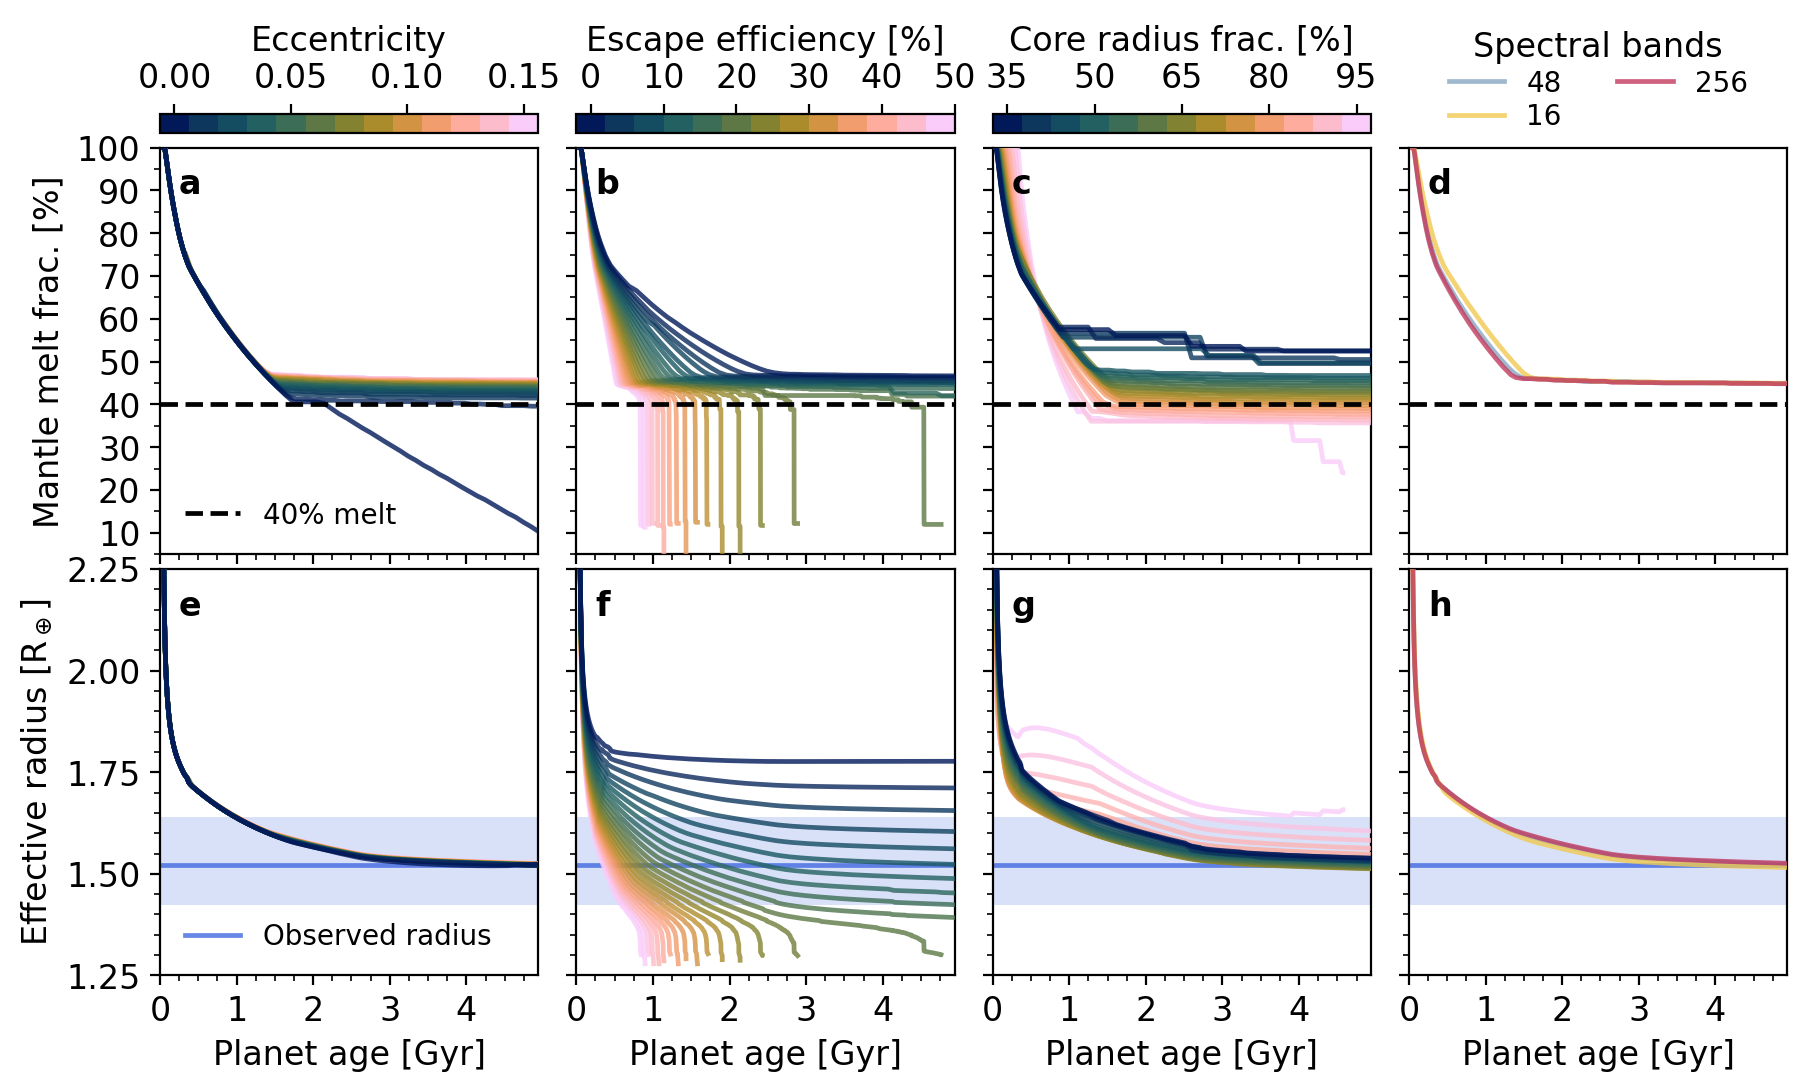

In [28]:
plt.close("all")

params = {
    "alpha"     : 0.8,
    "lw"        : 1.7,
    "dsmp"      : 2,
}

tests = [
    (gr_ecc, "orbit.eccentricity",              "Eccentricity",            1,   np.arange(0, 0.2, 0.05)),
    (gr_esc, "escape.zephyrus.efficiency",      "Escape efficiency [%]", 100,   np.arange(0, 60, 10.0)),
    (gr_crf, "struct.corefrac",                 "Core radius frac. [%]", 100,   np.arange(35, 100, 15.0)),
    (gr_ban, "atmos_clim.agni.spectral_bands",  "Spectral bands",          1,   []),
]

x_ini = lg.descend_get(gr_ecc.cvars[0], "star.age_ini") * 1e9
x_now = 4.94e9

fig, axs = plt.subplots(3,len(tests), sharex=True, figsize=(10.5,6), height_ratios=(0.1, 0.5, 0.5))

for j in range(len(tests)):

    grid, z_key, z_lbl, z_scl, z_tcks = tests[j]

    if len(z_tcks) == 0:
        z_tcks = None

    print(f"Plotting grid {grid.dir}")

    # get all z values from the grid
    z_vals = []
    for i in range(0,grid.ncases,params["dsmp"]):
        z_val = lg.descend_get(grid.cvars[i],z_key)
        z_vals.append(float(z_val)*z_scl)
    z_vals = np.unique(z_vals)

    # make scalar mappable if needed
    cbar = False
    if len(z_vals) > 5:
        z_min = np.min(z_vals)
        z_max = np.max(z_vals)
        norm = mpl.colors.Normalize(vmin=z_min, vmax=z_max)
        sm = plt.cm.ScalarMappable(cmap=cm.batlow, norm=norm)
        sm.set_array([])
        cbar = True

    # plot all cases from the grid
    for i in range(grid.ncases)[::-1]:
        # get z value
        z_val = float(lg.descend_get(grid.cvars[i],z_key)) * z_scl
        if cbar:
            col = sm.to_rgba(z_val)
        else:
            col = plt.get_cmap("Escher")(i/(grid.ncases-1))

        lbl = ""
        if j == np.shape(axs)[1]-1:
            lbl = "%g"%z_val

        # left axis
        ax = axs[1,j]
        x_arr = np.array(grid.helps[i]["Time"] + x_ini) / 1e9
        y_arr = np.array(grid.helps[i]["Phi_global"])*100
        ax.plot(x_arr, y_arr, c=col, alpha=params["alpha"], lw=params["lw"], label=lbl, zorder=10)

        # right axis
        ax = axs[2,j]
        x_arr = np.array(grid.helps[i]["Time"] + x_ini) / 1e9
        y_arr = np.array(grid.helps[i]["R_obs"])/R_earth
        ax.plot(x_arr, y_arr, c=col, alpha=params["alpha"], lw=params["lw"],  zorder=10)

    # colorbar?
    if cbar:
        cbar = plt.colorbar(sm, ax=axs[0,j], fraction=1, location='top', pad=0, values=z_vals)
        cbar.set_label(z_lbl)
        if z_tcks is not None:
            print(z_tcks)
            cbar.set_ticks(z_tcks)
    else:
        axs[1,j].legend(title=z_lbl, frameon=False, fontsize=10,
                            labelspacing=0.2, ncols=2,
                            loc='lower center', bbox_to_anchor=(0.5, 0.98))

for ax in axs[0,:]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axis_off()

xmin = 0
xmax = x_now/1e9
for ax in axs[-1,:]:
    ax.set_xlabel("Planet age [Gyr]")
    ax.set_xlim(left=xmin, right=xmax)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

c_obs = 'royalblue'

axs[1,0].set_ylabel("Mantle melt frac. [%]")
for j,ax in enumerate(axs[1,:]):
    ax.set_ylim(5,100)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    if j > 0:
        ax.set_yticklabels([])

    ax.axhline(y=40.0, color='k', lw=params["lw"], ls='--', zorder=12, label="40% melt")
    if j == 0:
        ax.legend( frameon=False, fontsize=10, loc='lower left')

axs[2,0].set_ylabel(r"Effective radius [R$_\oplus$]")
for j,ax in enumerate(axs[2,:]):
    ax.set_ylim(1.25,2.25)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    if j > 0:
        ax.set_yticklabels([])

    y = 1.521
    ax.fill_between([xmin,xmax],y+0.119,y-0.098, color=c_obs, zorder=1, alpha=0.2, edgecolor='none')
    ax.axhline(y=y, color=c_obs, lw=params["lw"], zorder=2, label="Observed radius", alpha=0.8)
    if j == 0:
        ax.legend( frameon=False, fontsize=10, loc='lower left')

for j,ax in enumerate(axs[1:,:].flatten()):
    ax.text(0.05, 0.95, alphabet[j], transform=ax.transAxes, zorder=99,
            fontsize=12, va='top', ha='left', fontweight='bold',)


fig.subplots_adjust(hspace=0.05, wspace=0.1)
plt.show()
fig.savefig("output/fig_sensitivity.pdf", bbox_inches='tight', dpi=300)